Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
188
GCN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
The task number 0
#########################################################################
Epoch: 005, Train Acc: 1.0000, Test Acc: 1.0000
Mem Train Acc: 1.0000, Mem Test Acc: 1.0000
#########################################################################
#########################################################################
Epoch: 010, Train Acc: 1.0000, Test Acc: 1.0000
Mem Train Acc: 1.0000, Mem Test Acc: 1.0000
#########################################################################
#########################################################################
Epoch: 015, Train Acc: 1.0000, Test Acc: 1.0000
Mem Train Acc: 1.0000, Mem Test Acc: 1.0000
#########################################################################
###################

([1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.34210526315789475,
  0.34210526315789475,
  0.6578947368421053,
  0.6578947368421053,
  0.6578947368421053,
  0.6578947368421053,
  0.6578947368421053,
  0.6578947368421053,
  0.6578947368421053])

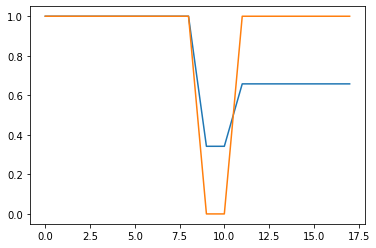

In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv 
from torch_geometric.nn import global_mean_pool
from Lib import *

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


def run(name_label, print_it, config):
    dataset= load_data(name_label)
    print(len(dataset))
    memory_train=[]
    memory_test=[]
    memory_valid=[]
    model = GCN(hidden_channels=64,\
        num_node_features= dataset.num_features,\
        num_classes=dataset.num_classes)
    print(model)
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    #import torch.optim.lr_scheduler as lrs
    #scheduler = lrs.ExponentialLR(optimizer, gamma=0.9)
    accuracies_mem = []
    accuracies_one=[]
    Total_loss=[]
    Gen_loss=[]
    For_loss=[]
    n_Tasks=dataset.num_classes

    for i in range(n_Tasks):
        print("The task number", i)
        train_loader, test_loader, mem_train_loader, mem_test_loader,\
            memory_train, memory_test = continuum_Graph_classification(dataset, memory_train, memory_test, batch_size=64, task_id=i)
        for epoch in range(1,50):
            Total,Gen,For=train_CL(model, criterion, optimizer, mem_train_loader, train_loader, task=i, graph=1, node=0, params=config)
            Total_loss.append(Total)
            Gen_loss.append(Gen)
            For_loss.append(For)
            if epoch%print_it==0:
                # scheduler.step()
                train_acc = test_GC(model, train_loader)
                test_acc = test_GC(model, test_loader)
                mem_train_acc = test_GC(model, mem_train_loader)
                mem_test_acc = test_GC(model, mem_test_loader)
                accuracies_mem.append(mem_test_acc)
                accuracies_one.append(test_acc)
                print("#########################################################################")
                print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
                print(f'Mem Train Acc: {mem_train_acc:.4f}, Mem Test Acc: {mem_test_acc:.4f}')
                print("#########################################################################")

    import matplotlib.pyplot as plt
    plt.plot(accuracies_mem, label='memory accuracy')
    plt.plot(accuracies_one, label='task accuracy')
    return accuracies_one, accuracies_mem

configuration = {'x_updates': 1,  'theta_updates':1, 'factor': 0.0001, 'x_lr': 0.0001,'th_lr':0.0001,\
            'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),\
            'batchsize':8, 'total_updates': 1000} 

run('MUTAG', print_it=5, config=configuration)